In [160]:
import os
from os.path import join
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import gc
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as T
import pytorch_lightning as pl 
from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.functional import accuracy
from torchsummaryX import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
seed_everything(42)
USE_CUDA = torch.cuda.is_available() 
AVAIL_GPUS = min(1, torch.cuda.device_count())
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
%matplotlib inline
print('pytorch version :',torch.__version__)
print('Training device :',device)
print('cuda index :', torch.cuda.current_device())
print('graphic name :', torch.cuda.get_device_name())

Global seed set to 42


pytorch version : 1.9.1
Training device : cuda:0
cuda index : 0
graphic name : NVIDIA GeForce RTX 3080 Ti


# EDA / Preprocessing

In [2]:
df = pd.read_pickle(r"C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\Week1\LSWMD.pkl")

In [3]:
def removebrackets(array):
    if array.shape == (1, 1):
        return "".join(array[0])
    elif array.shape == (0, 0):
        return None

df.rename(columns = {'trianTestLabel':'TrainTestLabel'}, inplace = 'True')
df['TrainTestLabel'] = df['TrainTestLabel'].apply(removebrackets)
df['failureType'] = df['failureType'].apply(removebrackets)
df = df.dropna()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172950 entries, 0 to 811454
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        172950 non-null  object 
 1   dieSize         172950 non-null  float64
 2   lotName         172950 non-null  object 
 3   waferIndex      172950 non-null  float64
 4   TrainTestLabel  172950 non-null  object 
 5   failureType     172950 non-null  object 
dtypes: float64(2), object(4)
memory usage: 9.2+ MB


In [5]:
df.isnull().sum()

waferMap          0
dieSize           0
lotName           0
waferIndex        0
TrainTestLabel    0
failureType       0
dtype: int64

In [6]:
df.head()

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none


In [7]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,Test,Edge-Ring


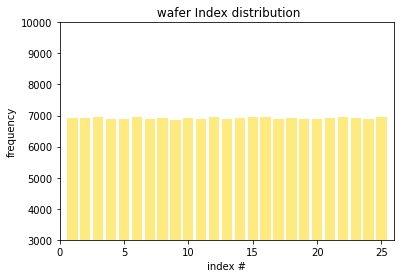

In [8]:
%matplotlib inline
uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(3000, 10000)
plt.show()
# 매우 균일한 분포를 보이므로, waferindex는 고려하지 않아도 됨.

In [9]:
df = df.drop(['waferIndex'], axis = 1)

In [10]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
    
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)
# waferMapDim 열 생성 

,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim
144888,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3036.0,lot9334,Training,Edge-Ring,"(63, 62)"
719149,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1256.0,lot43795,Test,none,"(41, 40)"
736354,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",741.0,lot44493,Test,none,"(33, 29)"
776748,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",935.0,lot46133,Test,none,"(35, 34)"
658613,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",776.0,lot41100,Test,none,"(30, 34)"


In [11]:
df.groupby("waferMapDim").size().sort_values(ascending=False)[:20]

waferMapDim
(25, 27)    18781
(26, 26)    14366
(30, 34)    12400
(29, 26)    11751
(27, 25)    10682
(39, 37)    10173
(33, 29)     8125
(42, 44)     6724
(44, 41)     6134
(41, 33)     5091
(35, 31)     4331
(25, 26)     4174
(41, 38)     4152
(33, 37)     3729
(29, 27)     2872
(45, 42)     2648
(43, 44)     2578
(41, 40)     2572
(41, 45)     2313
(38, 36)     2127
dtype: int64

In [12]:
label = df.failureType.values
encoder = LabelEncoder()
label = encoder.fit_transform(label)
print(label)
print(len(label))

[8 8 8 ... 3 2 3]
172950


In [13]:
y = label
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

faulty_case_dict = {}
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y[y==f]))) # y[y==f] : y에서 y==f인 행들만 뽑는다
    faulty_case_dict[i] = f

Faulty case list : [0 1 2 3 4 5 6 7 8]
0 : 4294
1 : 555
2 : 5189
3 : 9680
4 : 3593
5 : 149
6 : 866
7 : 1193
8 : 147431


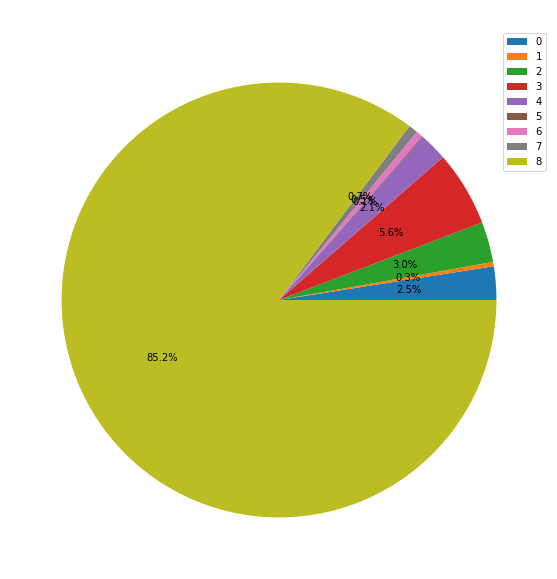

In [14]:
# failureType

plt.figure(figsize=(10, 10))
labels = np.unique(y, return_counts=True)[0]
counts = np.unique(y, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

# Loc, Edge-loc에 비해 Near-full, Donut들의 인스턴스 개수가 매우 작음.

In [15]:
# None 클래스 드랍
NONE = df.loc[(df.failureType == 'none'),:].sample(10000)
df.drop(df[df.failureType == 'none'].index, inplace = True)
print(NONE.shape)
print(df.shape)

(10000, 6)
(25519, 6)


In [16]:
df = pd.concat([df, NONE], ignore_index=True)
df.shape

(35519, 6)

In [17]:
label = df.failureType.values
encoder = LabelEncoder()
label = encoder.fit_transform(label)
print(label)
print(len(label))

[4 2 2 ... 8 8 8]
35519


In [18]:
y = label
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

faulty_case_dict = {}
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y[y==f]))) # y[y==f] : y에서 y==f인 행들만 뽑는다
    faulty_case_dict[i] = f

Faulty case list : [0 1 2 3 4 5 6 7 8]
0 : 4294
1 : 555
2 : 5189
3 : 9680
4 : 3593
5 : 149
6 : 866
7 : 1193
8 : 10000


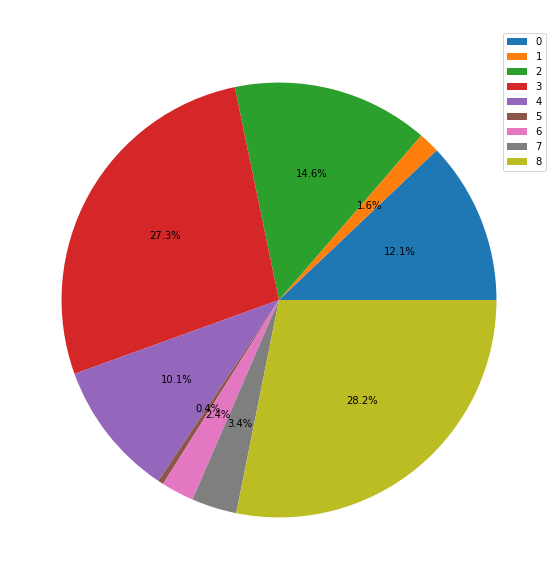

In [19]:
# None 드랍 후의 failureType 분포

plt.figure(figsize=(10, 10))
labels = np.unique(y, return_counts=True)[0]
counts = np.unique(y, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

## Resize

In [20]:
df.iloc[0].waferMap.shape # 2차원

(45, 48)

In [21]:
size = 64
def resize(arr):
    img = Image.fromarray(arr)
    img = img.resize((size, size), Image.BICUBIC)
    return np.asarray(img)
# 킹재우
def vis(x, y, label):
    fig = plt.figure(figsize=(8, 24))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax1.matshow(x)
    ax1.axis("off")
    ax1.set_title("Original of " + str(label))
    ax2.matshow(y)
    ax2.axis("off")
    ax2.set_title("Cubic of " + str(label))
    plt.show()

In [22]:
df['resized_wafer']=df.waferMap.apply(resize)

In [23]:
df.head()

,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim,resized_wafer
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,Loc,"(45, 48)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,Training,Edge-Loc,"(53, 58)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,Training,Edge-Loc,"(53, 58)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,Training,Edge-Loc,"(53, 58)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,Training,Edge-Loc,"(53, 58)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


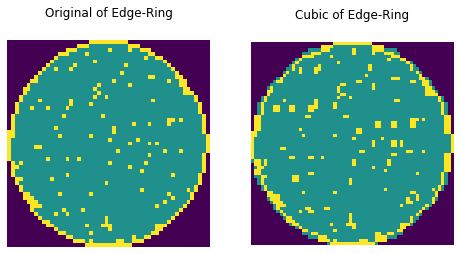

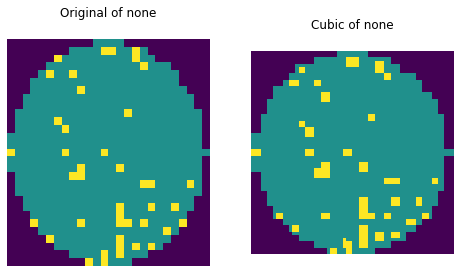

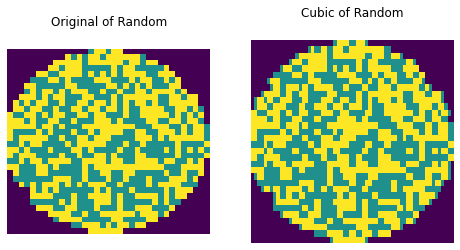

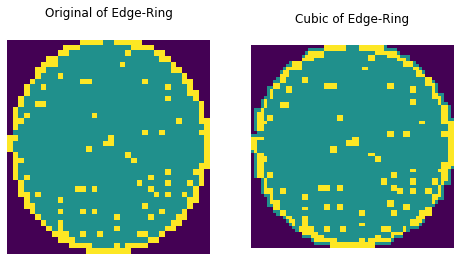

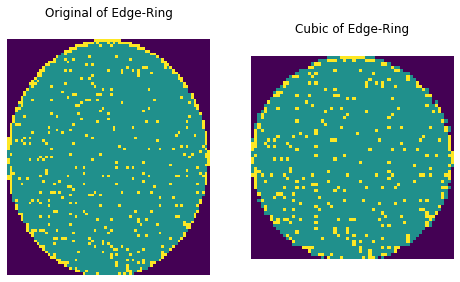

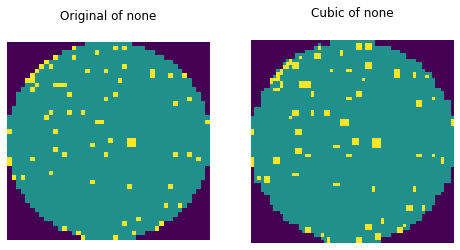

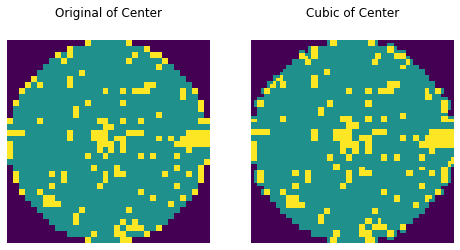

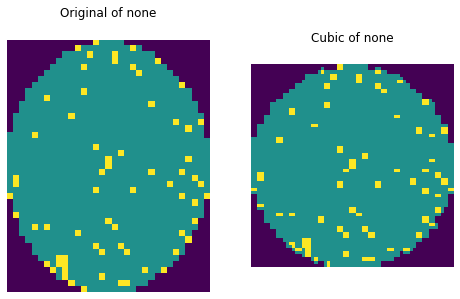

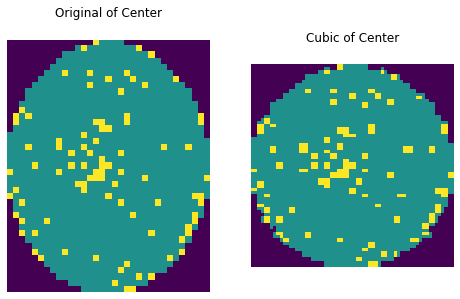

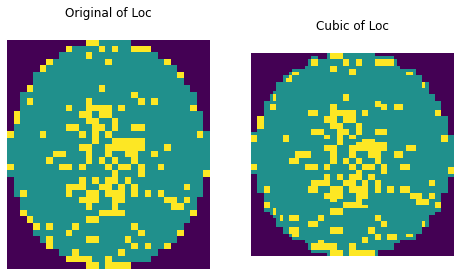

In [24]:
number_of_sample = 10
sample = df.sample(number_of_sample)
WAFER = sample.waferMap.values
CUBIC = sample.resized_wafer.values
LB = sample.failureType.values
for i in range(number_of_sample):
  vis(WAFER[i], CUBIC[i], LB[i])

# Create Dataset

In [25]:
images = df.resized_wafer.values
X = np.empty((len(images), size, size))
for i in range(len(images)):
  X[i,:,:] = images[i]
X = X.reshape((-1, 1, size, size))
print('X shape : {}, y shape : {}'.format(X.shape, y.shape))

X shape : (35519, 1, 64, 64), y shape : (35519,)


In [26]:
BATCH_SIZE = 256

X = torch.as_tensor(X, dtype=torch.float)
y = torch.as_tensor(y, dtype=torch.long)
dataset = TensorDataset(X, y)
train_indices, val_indices = train_test_split(list(range(len(y))), test_size=0.2, stratify=y)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
sample = next(iter(train_loader))
print('Dataset Shape: {}'.format(sample[0].shape))

Dataset Shape: torch.Size([256, 1, 64, 64])


In [27]:
'''
# One-Hot Encoding
new_x = np.empty((len(x), 4, 128, 128),dtype=int)

for w in tqdm(range(len(x))):
    for i in range(128):
        for j in range(128):
            new_x[w, int(x[w, :, i, j]), i, j] = 1
            '''

'\n# One-Hot Encoding\nnew_x = np.empty((len(x), 4, 128, 128),dtype=int)\n\nfor w in tqdm(range(len(x))):\n    for i in range(128):\n        for j in range(128):\n            new_x[w, int(x[w, :, i, j]), i, j] = 1\n            '

# Variational Autoencoder for augmentation

## 모델 구조

In [28]:
'''
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encode1 = self.encoder_block(1, 16)
        self.encode2 = self.encoder_block(16, 32)
        self.encode3 = self.encoder_block(32, 64)
        self.encode4 = self.encoder_block(64, 128)
        self.encode5 = self.encoder_block(128, 256)
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def encoder_block(self, c_in, c_out):  # Conv2d - relu - batchnorm 수행 
        encode = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(c_out)
        )
        return encode

    def forward(self, x):               # Encode x 3 -maxpool-encode-maxpool-encode      
        x = self.encode1(x)                   
        x = self.encode2(x)
        x = self.maxpool(x)
        x = self.encode3(x)
        x = self.encode4(x)
        x = self.maxpool(x)      
        x = self.encode5(x)                 
        return x 

# Upsampling할때 Conv2d로 업샘플링하는거 실패.
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decode1 = self.decoder_block(256, 128)             
        self.decode2 = self.decoder_block(128, 64, stride=2, output_padding=1)  # Upsample
        self.decode3 = self.decoder_block(64, 32)
        self.decode4 = self.decoder_block(32, 16, stride=2, output_padding=1)   # Upsample
        self.decode5 = self.decoder_block(16, 1)              
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample_bicubic = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=True)

    def decoder_block(self, c_in, c_out, stride=1, padding=1, output_padding=0):             
        decode = nn.Sequential(
            nn.ConvTranspose2d(
                c_in, c_out, kernel_size=3, stride=stride, 
                padding=padding, output_padding=output_padding
                ), # ConvTR2d - relu - batchnorm 수행, stride가 주어질 경우 upsample, output에 padding 추가
            nn.ReLU(),
            nn.BatchNorm2d(c_out), 
        )
        return decode

    def forward(self, x):
        x = self.decode1(x)           
        x = self.decode2(x)
        x = self.decode3(x)
        x = self.decode4(x)
        x = self.decode5(x) 
        return x
        
BATCH_SIZE = 256
'''

"\nclass Encoder(nn.Module):\n    def __init__(self):\n        super(Encoder, self).__init__()\n        self.encode1 = self.encoder_block(1, 16)\n        self.encode2 = self.encoder_block(16, 32)\n        self.encode3 = self.encoder_block(32, 64)\n        self.encode4 = self.encoder_block(64, 128)\n        self.encode5 = self.encoder_block(128, 256)\n        self.maxpool = nn.MaxPool2d(kernel_size=2)\n\n    def encoder_block(self, c_in, c_out):  # Conv2d - relu - batchnorm 수행 \n        encode = nn.Sequential(\n            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1),\n            nn.ReLU(),\n            nn.BatchNorm2d(c_out)\n        )\n        return encode\n\n    def forward(self, x):               # Encode x 3 -maxpool-encode-maxpool-encode      \n        x = self.encode1(x)                   \n        x = self.encode2(x)\n        x = self.maxpool(x)\n        x = self.encode3(x)\n        x = self.encode4(x)\n        x = self.maxpool(x)      \n        x = self.encode5(x)         

In [179]:
class ConvVAE(nn.Module):
    def __init__(self, alpha=1, Input_channels=1, imgsize=64*64, zDim=256):
        super().__init__()
        self.alpha=1
        self.imgsize = 64*64

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(Input_channels, 8, 3, padding=1)
        self.encConv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.encConv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.encConv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.encFC_mu = nn.Linear(64*imgsize, zDim)
        self.encFC_var = nn.Linear(64*imgsize, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, 64*imgsize)
        self.decConv1 = nn.ConvTranspose2d(64, 32, 3, padding=1)
        self.decConv2 = nn.ConvTranspose2d(32, 16, 3, padding=1)
        self.decConv3 = nn.ConvTranspose2d(16, 8, 3, padding=1)
        self.decConv4 = nn.ConvTranspose2d(8, 1, 3, padding=1)

    def encoder(self, x):
        imgsize = self.imgsize
        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = F.relu(self.encConv3(x))
        x = F.relu(self.encConv4(x))
        x = x.view(-1, 64*imgsize) # FLATTEN
        mu = self.encFC_mu(x)
        logVar = self.encFC_var(x)
        return mu, logVar

    def reparameterize(self, mu, log_var):
        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 64, 64, 64) # FLATTEN
        x = F.relu(self.decConv1(x))
        x = F.relu(self.decConv2(x))
        x = F.relu(self.decConv3(x))
        x = torch.sigmoid(self.decConv4(x))
        return x

    def forward(self, x):
        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

cvae = ConvVAE()
summary(cvae, torch.zeros(BATCH_SIZE, 1, size, size))

               Kernel Shape       Output Shape    Params  Mult-Adds
Layer                                                              
0_encConv1     [1, 8, 3, 3]   [256, 8, 64, 64]        80     294912
1_encConv2    [8, 16, 3, 3]  [256, 16, 64, 64]      1168    4718592
2_encConv3   [16, 32, 3, 3]  [256, 32, 64, 64]      4640   18874368
3_encConv4   [32, 64, 3, 3]  [256, 64, 64, 64]     18496   75497472
4_encFC_mu    [262144, 256]         [256, 256]  67109120   67108864
5_encFC_var   [262144, 256]         [256, 256]  67109120   67108864
6_decFC1      [256, 262144]      [256, 262144]  67371008   67108864
7_decConv1   [32, 64, 3, 3]  [256, 32, 64, 64]     18464   75497472
8_decConv2   [16, 32, 3, 3]  [256, 16, 64, 64]      4624   18874368
9_decConv3    [8, 16, 3, 3]   [256, 8, 64, 64]      1160    4718592
10_decConv4    [1, 8, 3, 3]   [256, 1, 64, 64]        73     294912
-------------------------------------------------------------------
                         Totals
Total params    

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_encConv1,"[1, 8, 3, 3]","[256, 8, 64, 64]",80,294912
1_encConv2,"[8, 16, 3, 3]","[256, 16, 64, 64]",1168,4718592
2_encConv3,"[16, 32, 3, 3]","[256, 32, 64, 64]",4640,18874368
3_encConv4,"[32, 64, 3, 3]","[256, 64, 64, 64]",18496,75497472
4_encFC_mu,"[262144, 256]","[256, 256]",67109120,67108864
5_encFC_var,"[262144, 256]","[256, 256]",67109120,67108864
6_decFC1,"[256, 262144]","[256, 262144]",67371008,67108864
7_decConv1,"[32, 64, 3, 3]","[256, 32, 64, 64]",18464,75497472
8_decConv2,"[16, 32, 3, 3]","[256, 16, 64, 64]",4624,18874368


In [180]:
len(train_loader) # BATCH 개수

111

In [181]:
len(train_loader.dataset)

28415

# AutoEncoder Train

In [187]:
def final_loss(recon_loss, mu, logVar, alpha):
    RECON = recon_loss
    KLD = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
    return alpha*RECON + KLD

def AE_train(loader, epoch, alpha=1):
    num_samples = len(loader.dataset)
    total_batches = len(loader)
    running_loss = 0.0 # Batch-wise
    model.train()
    for batch_idx, (X, _) in enumerate(tqdm(loader)): # 모든 배치에 대해 loop
        X = X.to(device).float() # move to device, e.g. GPU
        # 순전파 
        out, mu, logVar = model(X)
        recon_loss = criterion(out, X)
        loss = final_loss(recon_loss, mu, logVar) # 1 배치의 평균 # Alpha*Reconstruction_loss + KL_Divergence

        # 역전파 
        optimizer.zero_grad()
        loss.backward()
        running_loss += loss.item()
        optimizer.step()

    train_loss = running_loss / total_batches
    writer.add_scalar('train_loss', train_loss, epoch)
    print('Epoch {} Train Loss {:.4f}'.format(epoch, train_loss))
            
def AE_validate(loader, epoch, alpha=1):
    #print("working on val set...")
    #num_samples = len(loader.dataset)
    running_loss=0.0
    total_batches = len(loader)
    model.eval() 
    with torch.no_grad():
        for batch_idx, (X, _) in enumerate(loader):
            X = X.to(device).float()
            out, mu, logVar = model(X)
            recon_loss = criterion(out, X)
            loss = final_loss(recon_loss, mu, logVar)
            running_loss += loss.item()
            
        val_loss = running_loss / total_batches
        scheduler.step(val_loss) # val_loss가 개선되지 않으면 lr scheduler 실행
        writer.add_scalar('val_loss', loss, epoch)
        print("EPOCH {} val_loss : {:.4f}".format(epoch, val_loss))

In [185]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
model = ConvVAE().to(device)

# parameter
BATCH_SIZE = 256
LEARNING_RATE = 0.005
NUM_EPOCHS = 10
alpha = 1.0
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=0.5,
                patience=3, 
                threshold=0.03,
                threshold_mode='rel',
                cooldown=1, 
                verbose=True
            )

In [186]:
for epoch in range(NUM_EPOCHS):
    AE_train(train_loader, epoch, alpha=alpha)
    AE_validate(val_loader, epoch, alpha=alpha)

100%|██████████| 111/111 [00:17<00:00,  6.51it/s]


Epoch 0 Train Loss 96071.8678
EPOCH 0 val_loss : 8.6460


100%|██████████| 111/111 [00:16<00:00,  6.59it/s]


Epoch 1 Train Loss 5.8417
EPOCH 1 val_loss : 4.2269


100%|██████████| 111/111 [00:17<00:00,  6.51it/s]


Epoch 2 Train Loss 3.8982
EPOCH 2 val_loss : 3.6747


100%|██████████| 111/111 [00:17<00:00,  6.50it/s]


Epoch 3 Train Loss 3.6216
EPOCH 3 val_loss : 3.5170


100%|██████████| 111/111 [00:17<00:00,  6.51it/s]


Epoch 4 Train Loss 3.4765
EPOCH 4 val_loss : 3.3789


100%|██████████| 111/111 [00:17<00:00,  6.50it/s]


Epoch 5 Train Loss 3.3359
EPOCH 5 val_loss : 3.2363


100%|██████████| 111/111 [00:16<00:00,  6.53it/s]


Epoch 6 Train Loss 3.1952
EPOCH 6 val_loss : 3.1023


100%|██████████| 111/111 [00:16<00:00,  6.59it/s]


Epoch 7 Train Loss 3.0619
EPOCH 7 val_loss : 2.9722


100%|██████████| 111/111 [00:16<00:00,  6.65it/s]


Epoch 8 Train Loss 2.9326
EPOCH 8 val_loss : 2.8461


100%|██████████| 111/111 [00:16<00:00,  6.66it/s]


Epoch 9 Train Loss 2.8075
EPOCH 9 val_loss : 2.7242


In [188]:
# CUDA 메모리 정리 
model.to('cpu')
torch.cuda.empty_cache() 
gc.collect()

0

In [190]:
# reconstruct original faulty wafer
x_sample = next(iter(train_loader))[0] # 이미지만
recon_x = list(model(x_sample))[0]

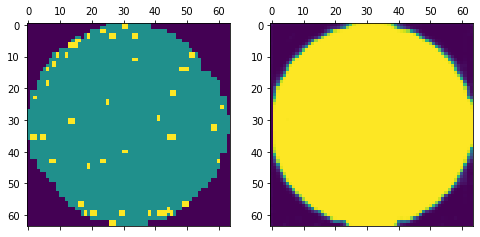

In [192]:
index = 50
fig = plt.figure(figsize=(8,12))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.matshow(x_sample[index][0]) 
ax2.matshow(recon_x.detach().numpy()[index][0])
plt.show()

## Data augmentation


In [ ]:
# augment function define
def gen_data(x, label):
    # Encode input x
    encoded_x = encoder(x)
    # dummy array for collecting noised x
    gen_x = torch.empty((len(x), 1, 128, 128), dtype=torch.float32)
    
    # Make x until total # of x to 5000
    for i in tqdm(range((5000//len(x)) + 1)):
        noised_encoded_x = encoded_x + torch.normal(mean=torch.zeros((len(encoded_x), 256, 13, 13)), std=STD*torch.ones((len(encoded_x), 256, 13, 13)))
        noised_gen_x = decoder(noised_encoded_x)
        gen_x[i] = noised_gen_x

    gen_y = torch.full((len(gen_x), 1), label, dtype=torch.int8)
    
    return gen_x, gen_y

In [ ]:
# reset
x = torch.as_tensor(x, dtype=torch.float32)
y = np.array(label).reshape((-1, 1))
y = torch.as_tensor(y, dtype=torch.int8)
print(x.shape)
print(noised_encoded_x.shape)
print(decoder(noised_encoded_x).shape)
print(y.shape)

In [ ]:
gc.collect()

In [ ]:
# Augmentation for all faulty case.
for f in tqdm(faulty_case) : 
    if f == 8 : # skip none case
        continue
    target_index = np.where(y==f)[0]
    gen_x, gen_y = gen_data(x[target_index], f)
    x = torch.cat((x, gen_x), axis=0)
    y = torch.cat((y, gen_y))

In [ ]:
print('After Generate X shape : {}, y shape : {}'.format(X.shape, y.shape))

In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

In [ ]:
# choice index without replace.
none_idx = np.where(y==8)[0][np.random.choice(len(np.where(y==8)[0]), size=11000, replace=False)]

In [ ]:
X = X.detach().numpy()
y = y.detach().numpy()

In [ ]:
# delete choiced index data.
new_x = np.delete(X, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [ ]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

In [ ]:
new_x = torch.tensor(new_x, dtype=torch.float32)
new_y = torch.tensor(new_y, dtype=torch.long)
dataset = TensorDataset(new_x, new_y)
train_indices, val_indices = train_test_split(list(range(len(new_y))), test_size = 0.2, stratify = new_y)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

sample = next(iter(train_loader))
print(sample[0].shape)
print(sample[1].shape)

### 모델 생성

# Transfer Learning

In [ ]:
from efficientnet_pytorch import EfficientNet 
model = EfficientNet.from_pretrained("efficientnet-b4", advprop=True, num_classes = 9) # Transfer learning
summary(model, torch.zeros(BATCH_SIZE, 3, 26, 26))

## Lightning Wrapper

In [ ]:
class LitEfficientNet(LightningModule):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
    
    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y) # for multi-class classification
        self.log("training loss", loss, on_step=True, prog_bar=True, logger=True)
        return loss 

    def evaluate(self, batch, stage=None):
        x, y = batch
        y_pred = self(x) # (batch,)
        loss = F.cross_entropy(y_pred, y)
        preds = y_pred.argmax(-1)
        acc = accuracy(preds, y)
        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True, logger=True)
            self.log(f"{stage}_accuracy", acc, prog_bar=True, logger=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.lr)
        steps_per_epoch = len(train_loader.dataset) // BATCH_SIZE
        scheduler_dict = {
            "scheduler": ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=0.1,
                patience=3, 
                threshold=0.0003,
                cooldown=2, 
                verbose=True
            ),
            "interval": "epoch",
            "monitor" : "val_loss", 
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

# Callback

In [ ]:

checkpoint = ModelCheckpoint(
    dirpath='./models',
    filename='model-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,
    monitor='val_loss',
    verbose=True,
    mode='min',
    save_weights_only=False,
    every_n_epochs = 1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.003,  # minimum value to determine 'improved'
    patience=5,
    verbose=True,
    mode='min'
) 
lr_monitor = LearningRateMonitor(logging_interval='step')

callbacks = [checkpoint, earlystop, lr_monitor]

# Classifier Training

In [ ]:
model = LitEfficientNet(lr = 0.005)
trainer = Trainer(
    progress_bar_refresh_rate = 10,
    min_epochs = 5,
    max_epochs = 50,
    gpus = 1,
    logger = TensorBoardLogger("logs", name = 'EfficientNetb4'), 
    callbacks = callbacks
)
trainer.fit(model, datamodule)

In [ ]:
%load_ext tensorboard